# EcodataLab2 
# Generating Estimates for Incomplement Electricity Consumption Dataset 
Author: Jiaxin Kathy Li and Christopher Jones 

Spring 2020

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')




# Related Dataset 1: Relationship File

Firstly, the dataset we will take advantage of is the census relationship files that include zip code population, population distribution ratio(s) within a zip code to counties, GEOID, etc. This would be the dataset we will use as the translator and connector between datasets. 




In [2]:
relationship = pd.read_csv('zcta_county_rel_10.txt')
relationship.head(2)

,ZCTA5,STATE,COUNTY,GEOID,POPPT,HUPT,AREAPT,AREALANDPT,ZPOP,ZHU,...,COAREA,COAREALAND,ZPOPPCT,ZHUPCT,ZAREAPCT,ZAREALANDPCT,COPOPPCT,COHUPCT,COAREAPCT,COAREALANDPCT
0,601,72,1,72001,18465,7695,165132671,164333375,18570,7744,...,173777444,172725651,99.43,99.37,98.61,98.6,94.77,94.71,95.03,95.14
1,601,72,141,72141,105,49,2326414,2326414,18570,7744,...,298027589,294039825,0.57,0.63,1.39,1.4,0.32,0.35,0.78,0.79


# Related Dataset 2: Elec_Master

The dataset that we are trying to fill is the elec_master speadsheet that former EcoDataLab staff had composed. It includes zip code, year, customer class(residential, industrial, commercial) and electricity consumption for each month as well the year average. Notably, if there is at least one nan value in the monthly data, the AnyNull? column would be True instead of False. 

Also, we would be working with residential dataset in this part since number of costumers for residential data would be population, in order to simplify our problem.

In [3]:
elec_m = pd.read_csv('Elec_Master.csv')

#adjusting some column types and focusing on residential 
elec_m = elec_m.astype({'ZCTA': int, 'Year':int})
elec_m_r = elec_m[elec_m['CustomerClass']=='residential']
elec_m_r.head(2)

,ZCTA,Year,CustomerClass,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,AnnualTotalAverage,anyNull?
1,90001,2014,residential,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,372.627938,308.556853,355.073121,1036.257911,True
3,90001,2015,residential,394.008751,309.371632,303.939084,310.553367,297.245193,311.423576,376.90958,380.741922,436.034409,415.524191,329.881948,405.894790,4271.528443,False


# Cleaning and Preliminary Operations on Two Datasets 

We would extract partial dataset from relationship file that is needed for the operations on Elec_Master by creating intermediate dataframes:
    1. ca_relationship: relationship file with on Californian zip codes extant in the Elec_Master dataset
    2. county_to_zcta: link each county code with a list of zip codes that are in this county
    3. zcta_to_county: link each zipcode with the county(counties) it is in/spanning. 
    4. zcta_pop: extract from relationship file, the zip code and corresponding population
    
There are other sanity checks and list_of_spanning_zctas that includes the zip codes that span multiple counties for test use. 




In [4]:
# narrowing the relationship files to the zipcodes that are extant in elem_m
zcta_in_elec_m = elec_m_r['ZCTA'].unique()
ca_relationship = relationship[relationship['ZCTA5'].isin(zcta_in_elec_m)]

# check if total number of zcta matches: TRUE
len(zcta_in_elec_m) == len(ca_relationship['ZCTA5'].unique())

# check the state is correct in ca_relationship
len(ca_relationship.groupby('STATE').agg('size').index) == 1

# extract list of counties and corresponding zip codes
len(ca_relationship['COUNTY'].unique()) # note: there are 56 counties recorded in ca_relationship not 58 in reality 
county_to_zcta = ca_relationship[['ZCTA5','COUNTY']].groupby('COUNTY').agg(list)
zcta_to_county = ca_relationship[['ZCTA5','COUNTY']].groupby('ZCTA5').agg(list)
# note: each zcta matches with 1-4 counties
# ca_relationship[['ZCTA5','COUNTY']].groupby('ZCTA5').agg(len)['COUNTY'].value_counts()

# extract population with regards to zipcode
zcta_pop_dup = ca_relationship[['ZCTA5', 'ZPOP']]
zcta_pop = zcta_pop_dup.groupby('ZCTA5').agg(np.mean).reset_index()

# test case designs:
list_of_spanning_zctas = zcta_to_county[[len(zcta_to_county['COUNTY'][x])>1 for x in zcta_to_county['COUNTY'].index]]

In [5]:
county_to_zcta.head(2)

,ZCTA5
COUNTY,
1,"[94505, 94514, 94536, 94538, 94539, 94541, 945..."
3,[95223]


In [6]:
zcta_to_county.head(2)

,COUNTY
ZCTA5,
90001,[37]
90002,[37]


In [7]:
zcta_pop.head(2)

,ZCTA5,ZPOP
0,90001,57110
1,90002,51223


# Estimate Generator 1: Simple Average

Method 1 is to fill in the nan values in the dataset by averaging existing data. For instance, for a missing value for zip code 90001 in Jan 2012, we would take the average of availble data in Jan 2012 in the same county as 90001 as the estimate. The average would be calculated by weighting the population in each available zip codes.

We would not be concerned with the fact that part of the population of some zipcodes resides in another county. This would be the crudest but most intuitive method we use.

In [8]:
# our experiment data set with nan values
elec_m_r_null = elec_m_r[elec_m_r['anyNull?']].drop(columns={'CustomerClass','anyNull?'})
elec_m_r_null.head(2)

,ZCTA,Year,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,AnnualTotalAverage
1,90001,2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,372.627938,308.556853,355.073121,1036.257911
9,90001,2018,NaN,NaN,NaN,297.724075,281.760463,325.519756,448.973293,511.219067,428.094725,332.256905,329.701573,352.293133,3307.542990


Here, we would conduct a sample run for this method for the nan value of 90001 in Jan 2014. 

Explanation: 90001 belongs to county 37. Existing data for county 37 in Jan 2014 has only one entry of 546.064516 in zip code 93243 with population of 1699. 90001 has population of 57110. The result is 18355.352864113618


Note: it turns out that in Jan 2014 there was only one availble entry of data. 

In [9]:
sample_county = zcta_to_county.loc[90001][0][0]
sample_county_zctas = county_to_zcta.loc[sample_county][0]
sample_county_zctas_located = elec_m_r[(elec_m_r['ZCTA'].isin(sample_county_zctas)) 
                                       & ~(elec_m_r['1.0'].isna())][['ZCTA','1.0','Year']]
sample_county_zctas_located_2014 = sample_county_zctas_located[sample_county_zctas_located['Year']==2014]
#turns out 2014 just one entry
# elec_m_r[(elec_m_r['Year']==2014) & (elec_m_r['ZCTA'].isin(sample_county_zctas))]['1.0'].value_counts()

sample_county_zctas_pop = zcta_pop[zcta_pop['ZCTA5'].isin(sample_county_zctas)]
sample_county_zctas_df = sample_county_zctas_located_2014.merge(sample_county_zctas_pop, how='left', 
                                                              left_on='ZCTA', right_on='ZCTA5')
sample_null_fillin = sum(sample_county_zctas_df['1.0']) / sum(sample_county_zctas_df['ZPOP']) * zcta_pop[zcta_pop['ZCTA5']==90001]['ZPOP'][0]
sample_null_fillin

18355.352864113618

Now, the function info_of_county would do the exact procedure done in the sample run. Given the zip code, month, year of some detected nan value in the Elec_Master dataset, this function would return the simple average estimate. It will also take care of the situation when one zip code belongs to multiple counties. In addition, get_pop function would be the helper function that returns the popualtion given one specific zip code.

We would furthermore conducting three tests using the function, including the validation of the sample run. Note: due to mathematical calculation, any two number with a difference of less than 0.000001 would be considered equal.

In [10]:
def info_of_county(zcta, month, year):
    county_codes = zcta_to_county.loc[zcta][0]
    zctas_related = []
    for county_code in county_codes:
        zctas_related.extend(county_to_zcta.loc[county_code][0])
    zctas_timed = elec_m_r[(elec_m_r['ZCTA'].isin(zctas_related)) 
                           & ~(elec_m_r[month].isna()) 
                           & (elec_m_r['Year']==year)][['ZCTA', month]]  
    zcta_related_pop = zcta_pop[zcta_pop['ZCTA5'].isin(zctas_related)]
    zctas_df = zctas_timed.merge(zcta_related_pop, how='left', left_on='ZCTA', right_on='ZCTA5')
    fill_in = np.sum(zctas_df[month]) / np.sum(zctas_df['ZPOP']) * zcta_pop[zcta_pop['ZCTA5']==zcta].reset_index()['ZPOP'][0]
    return fill_in

def get_pop(zcta):
    return zcta_pop[zcta_pop['ZCTA5']==zcta5].reset_index()['ZPOP'][0]

In [11]:
# test 1: validation of the sample run
info_of_county(90001, '1.0', 2014) == sample_null_fillin

True

In [12]:
# test case 2: nan value at 90001, 2017, Jan

# automated function method
automated_2 = info_of_county(90001, '1.0', 2017)

# sample run copy: the manual method 
sample_county_2 = zcta_to_county.loc[90001][0][0]
sample_county_zctas_2 = county_to_zcta.loc[sample_county_2][0]
sample_county_zctas_located_2 = elec_m_r[(elec_m_r['ZCTA'].isin(sample_county_zctas_2)) 
                                       & ~(elec_m_r['1.0'].isna())][['ZCTA','1.0','Year']]
sample_county_zctas_located_2018_2 = sample_county_zctas_located_2[sample_county_zctas_located_2['Year']==2017]
sample_county_zctas_pop_2 = zcta_pop[zcta_pop['ZCTA5'].isin(sample_county_zctas_2)]
sample_county_zctas_df_2 = sample_county_zctas_located_2018_2.merge(sample_county_zctas_pop_2, how='left', 
                                                              left_on='ZCTA', right_on='ZCTA5')
sample_null_fillin_2 = sum(sample_county_zctas_df_2['1.0']) / sum(sample_county_zctas_df_2['ZPOP']) * zcta_pop[zcta_pop['ZCTA5']==90001]['ZPOP'][0]

print(automated_2 - sample_null_fillin_2 < 0.000001, automated_2)
# test case 2 passed!

True 892.2504208890066


In [13]:
# test case 3: (multiple county spanned)90265, Jan, 2017

# automated function method
automated_3 = info_of_county(90265, '1.0', 2017)

# sample run copy: the manual method
sample_county_3 = zcta_to_county.loc[90265][0]
sample_county_zctas_1_3 = county_to_zcta.loc[sample_county_3]['ZCTA5'][37]
sample_county_zctas_2_3 = county_to_zcta.loc[sample_county_3]['ZCTA5'][111]
sample_county_zctas_3 = sample_county_zctas_1_3 + sample_county_zctas_2_3

sample_county_zctas_located_3 = elec_m_r[(elec_m_r['ZCTA'].isin(sample_county_zctas_3)) 
                                       & ~(elec_m_r['1.0'].isna())][['ZCTA','1.0','Year']]
sample_county_zctas_located_2017_3 = sample_county_zctas_located_3[sample_county_zctas_located_3['Year']==2017]
sample_county_zctas_pop_3 = zcta_pop[zcta_pop['ZCTA5'].isin(sample_county_zctas_3)]
sample_county_zctas_df_3 = sample_county_zctas_located_2017_3.merge(sample_county_zctas_pop_3, how='left', 
                                                              left_on='ZCTA', right_on='ZCTA5')
sample_null_fillin_3 = sum(sample_county_zctas_df_3['1.0']) / sum(sample_county_zctas_df_3['ZPOP']) * zcta_pop[zcta_pop['ZCTA5']==90265].reset_index()['ZPOP'][0]

print(sample_null_fillin_3 - automated_3 < 0.0000001, automated_3)
# test case 3 passed!

True 286.99598217935153




Notably, the result for test case 3 is very low(286) compared to real number(1181). For some sanity checks for our algorithm, we would check if this issue is due to systematic error or chance.
    1. Check if there exists substantial consumption and/or population difference for county 111 and 37
            -Turned out that the difference for county 111 and 37 is not sufficient enough to explain the result
    2. Check if this zip code is a unicorn, that is, if existing data for this zip code is substantially different 
        from the trend detected in other zip codes in the same counties. 
            -Turned out it was a unicorn--this algorithm is not sufficient detecting unicorns using simple average. 




In [14]:
# Check 1: if there exists difference in different counties of 111 and 37

# for county 37: sample_county_zctas_1_3
sample_county_zctas_located_37 = elec_m_r[(elec_m_r['ZCTA'].isin(sample_county_zctas_1_3)) 
                                       & ~(elec_m_r['1.0'].isna())][['ZCTA','1.0','Year']]
sample_county_zctas_located_2017_37 = sample_county_zctas_located_37[sample_county_zctas_located_37['Year']==2017]
sample_county_zctas_pop_37 = zcta_pop[zcta_pop['ZCTA5'].isin(sample_county_zctas_1_3)]
sample_county_zctas_df_37 = sample_county_zctas_located_2017_37.merge(sample_county_zctas_pop_37, how='left', 
                                                              left_on='ZCTA', right_on='ZCTA5')
sample_null_fillin_37 = sum(sample_county_zctas_df_37['1.0']) / sum(sample_county_zctas_df_37['ZPOP']) * zcta_pop[zcta_pop['ZCTA5']==90265].reset_index()['ZPOP'][0]

# for county 111: sample_county_zctas_2_3
sample_county_zctas_located_111 = elec_m_r[(elec_m_r['ZCTA'].isin(sample_county_zctas_2_3)) 
                                       & ~(elec_m_r['1.0'].isna())][['ZCTA','1.0','Year']]
sample_county_zctas_located_2017_111 = sample_county_zctas_located_111[sample_county_zctas_located_111['Year']==2017]
sample_county_zctas_pop_111 = zcta_pop[zcta_pop['ZCTA5'].isin(sample_county_zctas_2_3)]
sample_county_zctas_df_111 = sample_county_zctas_located_2017_111.merge(sample_county_zctas_pop_111, how='left', 
                                                              left_on='ZCTA', right_on='ZCTA5')
sample_null_fillin_111 = sum(sample_county_zctas_df_111['1.0']) / sum(sample_county_zctas_df_111['ZPOP']) * zcta_pop[zcta_pop['ZCTA5']==90265].reset_index()['ZPOP'][0]

print(sample_null_fillin_37, sample_null_fillin_111, (sample_null_fillin_37+sample_null_fillin_111)*.5)

# not really that much difference 

283.0328948489798 376.16967302402446 329.6012839365021


Predicted:  286.9959821793515
90265 pop:  18116
Regional pop average:  35232.52558139535
Regional concumption average:  558.1581631646989


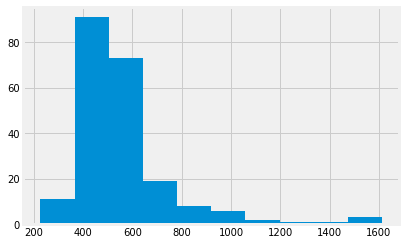

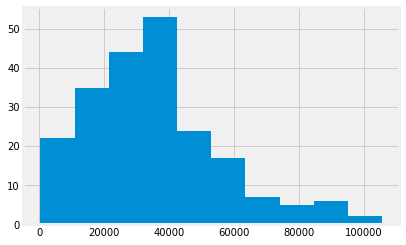

In [15]:
# Check 2: Is 90265 a unicorn?

# Graphing general trends
plt.figure(figsize=(6,4))
plt.hist(sample_county_zctas_df_3['1.0'])
plt.figure(figsize=(6,4))
plt.hist(sample_county_zctas_df_3['ZPOP'])


fraction = sum(sample_county_zctas_df_3['1.0']) / sum(sample_county_zctas_df_3['ZPOP'])
pop_90265 = zcta_pop[zcta_pop['ZCTA5']==90265].reset_index()['ZPOP'][0]
result = fraction*pop_90265
print("Predicted: ", result)
print("90265 pop: ", pop_90265)
print("Regional pop average: ", np.mean(sample_county_zctas_df_3['ZPOP']))
print("Regional concumption average: ", np.mean(sample_county_zctas_df_3['1.0']))

# turns out it is a unicorn! 

After validating that the algorithm does what is intended, we would conduct one whole trial to fill in missing values for Jan 2017. If the trial is successful, we would write the function that would simulate this trial process. Subsequently, we would update the whole Elec_Master using this function. 

In [16]:
# One Whole Trial for Jan 2017

jan_17 = elec_m_r[elec_m_r['Year']==2017][['ZCTA','1.0']]
jan_17_nans = jan_17[jan_17['1.0'].isna()]
jan_17_nans_index = jan_17_nans.index
jan_17_nans_zcta = jan_17_nans.reset_index()['ZCTA']

for i in np.arange(len(jan_17_nans_index)):
    predicted = info_of_county(jan_17_nans_zcta[i], '1.0', 2017)
    jan_17.at[jan_17_nans_index[i],'1.0']= predicted
    
jan_17.head()

,ZCTA,1.0
7,90001,405.925572
17,90002,450.001840
23,90008,731.553914
32,90022,393.119911
44,90023,371.428903


In [17]:
# function to simulate a whole trial 
def fill_in_df(df, year, month):
    target_df = df[df['Year']==year][['ZCTA',month]]
    target_df_nans = target_df[target_df[month].isna()]
    nan_index = target_df_nans.index
    nan_zcta = target_df_nans.reset_index()['ZCTA']
    for i in np.arange(len(nan_index)):
        predicted = info_of_county(nan_zcta[i], month, year)
        df.at[nan_index[i], month] = predicted 

In [18]:
# Updating the whole dataframe
auto_copy = elec_m_r.copy()

years = np.arange(2012,2019)
months = elec_m_r.columns[3:15]

for y in years:
    for m in months:
        fill_in_df(auto_copy, y, m)

/srv/conda/envs/data100/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


In [19]:
auto_copy.head()

,ZCTA,Year,CustomerClass,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,AnnualTotalAverage,anyNull?
1,90001,2014,residential,18355.352864,16201.663944,16275.815024,15189.871547,15384.546947,17746.125090,22965.937286,20546.123534,17753.466055,372.627938,308.556853,355.073121,1036.257911,True
3,90001,2015,residential,394.008751,309.371632,303.939084,310.553367,297.245193,311.423576,376.909580,380.741922,436.034409,415.524191,329.881948,405.894790,4271.528443,False
5,90001,2016,residential,418.239454,333.234580,311.567439,292.656686,283.999390,337.761106,391.395608,403.500102,377.435561,353.180204,341.638390,370.511595,4215.120114,False
7,90001,2017,residential,405.925572,371.139803,305.547464,290.939240,294.020655,334.279278,414.562639,410.375547,431.539658,343.187722,346.311922,341.624732,4289.454234,False
9,90001,2018,residential,19338.882588,18274.261290,20206.255706,297.724075,281.760463,325.519756,448.973293,511.219067,428.094725,332.256905,329.701573,352.293133,3307.542990,True


Sanity checks for if the dataset has been filled in. Turns out it was not fully filled in. There exists a clear pattern of the number of unfilled values. This problem is due to the fact that during specific months in specific years, there exists no available values to base the estimate on. 

In [20]:
check = auto_copy.iloc[:,3:15].isna()
print(sum(check['1.0']),
     sum(check['2.0']),
     sum(check['3.0']),
     sum(check['4.0']),
     sum(check['5.0']),
     sum(check['6.0']),
      sum(check['7.0']),
     sum(check['8.0']),
     sum(check['9.0']),
     sum(check['10.0']),
     sum(check['11.0']),
     sum(check['12.0']))

158 158 158 79 79 79 79 79 79 0 0 0


In [21]:
auto_copy[auto_copy['1.0'].isna()]['Year'].value_counts()

2018    79
2014    79
Name: Year, dtype: int64

To improve the performance of our algorithm on detecting unicorns and handling zip codes with substantial difference to other zip codes in the same county, we would add on a plugboard that takes into account the existing values for this zip code in other months this year. The methodology is explained as follows: 
    1. Average the existing data for this zip code in this year
    2. Divide this by the average of county for the same month(s). We would leave with a fraction that illustrate the status of this zip code with respect to the entire county(fraction of below/above average by some amount).
    3. Calculate as usual but correct the final number by this fraction at the end. 

In [22]:
# sample run for this fraction correction method

fraction_non_corrected_automated = info_of_county(90265, '1.0', 2017)

avg_90001_2014 = np.mean(np.mean(elec_m_r[(elec_m_r['ZCTA'] == 90265) & (elec_m_r['Year'] == 2017)].iloc[:, 3:15]))
months_90001_2014 = np.sum(elec_m_r[(elec_m_r['ZCTA'] == 90265) & (elec_m_r['Year'] == 2017)].iloc[:, 3:15].notna())
all_months = ['1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0', '12.0']
select_months = []
for mon in all_months:
    if months_90001_2014[mon] != 0:
        select_months.append(mon)

avg_all_county = np.mean(np.mean(elec_m_r[(elec_m_r['Year']==2017) & 
                      (elec_m_r['ZCTA'].isin(sample_county_zctas_3))].loc[:, select_months]))

fraction = avg_90001_2014/avg_all_county

print(fraction_non_corrected_automated * fraction, fraction_non_corrected_automated)

575.2024475227679 286.99598217935153


In [23]:
# Fraction correction function 
def correct_fractioned(zcta, month, year):
    automated = info_of_county(zcta, month, year)
    existing_data = np.mean(np.mean(elec_m_r[(elec_m_r['ZCTA'] == zcta) & (elec_m_r['Year'] == year)].iloc[:, 3:15]))
    available_months = np.sum(elec_m_r[(elec_m_r['ZCTA'] == zcta) & (elec_m_r['Year'] == year)].iloc[:, 3:15].notna())
    all_months = ['1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0', '12.0']
    select_months = []
    for mon in all_months:
        if available_months[mon] != 0:
            select_months.append(mon)
    county_codes = zcta_to_county.loc[zcta][0]
    zctas_related = []
    for county_code in county_codes:
        zctas_related.extend(county_to_zcta.loc[county_code][0])   
    avg_all_county = np.mean(np.mean(elec_m_r[(elec_m_r['Year']==year) & 
                      (elec_m_r['ZCTA'].isin(zctas_related))].loc[:, select_months]))
    if avg_all_county == 0:
        avg_all_county = np.mean(np.mean(elec_m_r[(elec_m_r['Year']==year)].loc[:, select_months]))
    return (existing_data/avg_all_county)*automated

In [24]:
correct_fractioned(90265, '1.0', 2017)  == fraction

False

In [25]:
# comparison: without new function 

jan_15 = elec_m_r[elec_m_r['Year']==2015][['ZCTA','1.0']]
jan_15_nans = jan_15[jan_15['1.0'].isna()]
jan_15_nans_index = jan_15_nans.index
jan_15_nans_zcta = jan_15_nans.reset_index()['ZCTA']


for i in np.arange(len(jan_15_nans_index)):
    predicted = info_of_county(jan_15_nans_zcta[i], '1.0', 2015)
    jan_15.at[jan_15_nans_index[i],'1.0']= predicted
    
jan_15.loc[jan_15_nans_index]

,ZCTA,1.0
54,90032,733.702327
4761,92386,46.441584
8055,93429,4.448946
8672,93563,6.217545
9793,93954,9.681480
14348,95565,237.030601
14389,95587,39.998890


In [26]:
# reference: nan zip codes 
elec_m_r.loc[jan_15_nans_index]

,ZCTA,Year,CustomerClass,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,AnnualTotalAverage,anyNull?
54,90032,2015,residential,NaN,285.63000,NaN,284.794118,NaN,NaN,NaN,388.558824,NaN,458.860000,NaN,NaN,1417.842941,True
4761,92386,2015,residential,NaN,NaN,NaN,109.722772,112.205882,NaN,130.721154,132.225490,NaN,144.764706,142.350000,NaN,771.990005,True
8055,93429,2015,residential,NaN,451.00000,565.383333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1016.383333,True
8672,93563,2015,residential,NaN,NaN,484.283019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,484.283019,True
9793,93954,2015,residential,NaN,NaN,NaN,NaN,507.702970,484.366337,496.805825,507.213592,483.227723,478.088235,643.074766,810.224299,4410.703748,True
14348,95565,2015,residential,NaN,896.97561,597.931298,656.313253,653.393782,598.082126,519.591304,526.131783,533.292308,546.362179,647.477124,749.409091,6924.959858,True
14389,95587,2015,residential,NaN,NaN,1100.416667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1100.416667,True


In [27]:
# run tests on the new function 
# One Whole Trial for Jan 2015

jan_15_cor = elec_m_r[elec_m_r['Year']==2015][['ZCTA','1.0']]
jan_15_nans_cor = jan_15_cor[jan_15_cor['1.0'].isna()]
jan_15_nans_index_cor = jan_15_nans_cor.index
jan_15_nans_zcta_cor = jan_15_nans_cor.reset_index()['ZCTA']

fractions = []

for i in np.arange(len(jan_15_nans_index_cor)):
    frac = correct_fractioned(jan_15_nans_zcta_cor[i], '1.0', 2015)
    fractions.append(frac)
    predicted_here = info_of_county(jan_15_nans_zcta_cor[i], '1.0', 2015)
    jan_15_cor.at[jan_15_nans_index_cor[i],'1.0']= frac * predicted_here
    
jan_15_cor.loc[jan_15_nans_index_cor]

,ZCTA,1.0
54,90032,335233.773727
4761,92386,477.541232
8055,93429,20.686401
8672,93563,41.290075
9793,93954,103.129620
14348,95565,42433.329025
14389,95587,2388.831878


In [28]:
fractions

[456.9070610634371,
 10.282621476770371,
 4.649730619558823,
 6.6408970824664415,
 10.652258096372652,
 179.02046780411192,
 59.72245429196499]

In [29]:
county = zcta_to_county.loc[93429][0][0]
list_of_zip = county_to_zcta.loc[county][0]
elec_m_r[(elec_m_r['ZCTA'].isin(list_of_zip)) & (elec_m_r['Year']==2015)]
zcta_pop[zcta_pop['ZCTA5'].isin(list_of_zip)]

,ZCTA5,ZPOP
485,93001,32990
490,93013,16091
505,93067,895
506,93101,31683
507,93103,20249
508,93105,24815
509,93108,11112
510,93109,10858
511,93110,16829
512,93111,17370


Now we will apply the correctly fractioned function to the whole dataset. Let's take a look at how our improved simple average algorithm works for the entire elec_master data set.

In [31]:
# function to simulate a whole trial using fraction 
def fill_in_df_with_frac(df, year, month):
    target_df = df[df['Year']==year][['ZCTA',month]]
    target_df_nans = target_df[target_df[month].isna()]
    nan_index = target_df_nans.index
    nan_zcta = target_df_nans.reset_index()['ZCTA']
    for i in np.arange(len(nan_index)):
        predicted = correct_fractioned(nan_zcta[i], month, year)
        df.at[nan_index[i], month] = predicted 

In [32]:
# Updating the whole dataframe using fractions 
auto_copy_frac = elec_m_r.copy()

years = np.arange(2012,2019)
months = elec_m_r.columns[3:15]

for y in years:
    for m in months:
        fill_in_df_with_frac(auto_copy_frac, y, m)

/srv/conda/envs/data100/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


In [33]:
auto_copy_frac

,ZCTA,Year,CustomerClass,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,AnnualTotalAverage,anyNull?
1,90001,2014,residential,11715.068028,10340.503759,10387.829732,9694.740266,9818.989338,11326.236233,14657.714272,13113.299249,11330.921509,372.627938,308.556853,355.073121,1036.257911,True
3,90001,2015,residential,394.008751,309.371632,303.939084,310.553367,297.245193,311.423576,376.909580,380.741922,436.034409,415.524191,329.881948,405.894790,4271.528443,False
5,90001,2016,residential,418.239454,333.234580,311.567439,292.656686,283.999390,337.761106,391.395608,403.500102,377.435561,353.180204,341.638390,370.511595,4215.120114,False
7,90001,2017,residential,405.925572,371.139803,305.547464,290.939240,294.020655,334.279278,414.562639,410.375547,431.539658,343.187722,346.311922,341.624732,4289.454234,False
9,90001,2018,residential,12586.730374,11893.820576,13151.261004,297.724075,281.760463,325.519756,448.973293,511.219067,428.094725,332.256905,329.701573,352.293133,3307.542990,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16176,96137,2014,residential,346.378378,296.436398,306.376453,297.728668,334.593366,362.625093,528.405797,429.268873,331.086617,323.479717,329.939642,356.969471,4243.288473,False
16177,96137,2015,residential,336.099665,244.579807,283.377745,290.832653,334.004443,365.677634,495.481153,404.029586,340.551775,310.465504,357.921160,391.568401,4154.589527,False
16179,96137,2016,residential,379.318841,305.223460,305.069517,278.507601,328.884288,356.761940,495.961936,415.466790,343.835052,331.120664,333.461567,389.612820,4263.224475,False
16181,96137,2017,residential,381.934517,309.779630,312.010733,300.681465,322.123940,377.828666,517.757531,432.454679,365.795513,334.378031,326.149798,376.035741,4356.930243,False


In [34]:
elec_m_r

,ZCTA,Year,CustomerClass,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,AnnualTotalAverage,anyNull?
1,90001,2014,residential,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,372.627938,308.556853,355.073121,1036.257911,True
3,90001,2015,residential,394.008751,309.371632,303.939084,310.553367,297.245193,311.423576,376.909580,380.741922,436.034409,415.524191,329.881948,405.894790,4271.528443,False
5,90001,2016,residential,418.239454,333.234580,311.567439,292.656686,283.999390,337.761106,391.395608,403.500102,377.435561,353.180204,341.638390,370.511595,4215.120114,False
7,90001,2017,residential,405.925572,371.139803,305.547464,290.939240,294.020655,334.279278,414.562639,410.375547,431.539658,343.187722,346.311922,341.624732,4289.454234,False
9,90001,2018,residential,NaN,NaN,NaN,297.724075,281.760463,325.519756,448.973293,511.219067,428.094725,332.256905,329.701573,352.293133,3307.542990,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16176,96137,2014,residential,346.378378,296.436398,306.376453,297.728668,334.593366,362.625093,528.405797,429.268873,331.086617,323.479717,329.939642,356.969471,4243.288473,False
16177,96137,2015,residential,336.099665,244.579807,283.377745,290.832653,334.004443,365.677634,495.481153,404.029586,340.551775,310.465504,357.921160,391.568401,4154.589527,False
16179,96137,2016,residential,379.318841,305.223460,305.069517,278.507601,328.884288,356.761940,495.961936,415.466790,343.835052,331.120664,333.461567,389.612820,4263.224475,False
16181,96137,2017,residential,381.934517,309.779630,312.010733,300.681465,322.123940,377.828666,517.757531,432.454679,365.795513,334.378031,326.149798,376.035741,4356.930243,False


# Summary of Methodology for Simple Average 

Goal: fill in missing values in the elec_master dataset

Step 1: find all zip codes that are or partly are inside the county that the missing value's zip code is in. 

Step 2: find all available data for the list of zip codes in the same month and year with the missing value.

Step 3: Take the average of the available data, scaled by missing value zip code's population over county population.

Step 4(Fractioned): Multiply the result in step 3 with the fraction of, the available data for the missing value's zip code in this year over the county's average of the same available month(s) in this year. 

In [35]:
zcta_to_county.loc[90001]
county_to_zcta.loc[37][0]
pop_90001_county = sum(zcta_pop[zcta_pop['ZCTA5'].isin(county_to_zcta.loc[37][0])]['ZPOP'])
pop_90001 = zcta_pop[zcta_pop['ZCTA5'] == 90001]['ZPOP'][0]

available_data = elec_m_r[(elec_m_r['Year'] == 2014) & 
             (elec_m_r['ZCTA'].isin(
                 county_to_zcta.loc[37][0]))][['10.0', '11.0', '12.0']].dropna()
county_avg = np.mean(np.mean(available_data['10.0']) + np.mean(available_data['11.0']) + np.mean(available_data['12.0']))
data_90001 = elec_m_r[(elec_m_r['Year'] == 2014) & 
             (elec_m_r['ZCTA'] == 90001)][['10.0', '11.0', '12.0']]
avg_90001 = np.mean(np.mean(data_90001['10.0']) + np.mean(data_90001['11.0']) +np.mean(data_90001['12.0']))

print('county pop: ', pop_90001_county)
print('90001 pop: ', pop_90001)
print('county average: ', county_avg)
print('90001 average: ', avg_90001)
print('90001 adjusted without fraction: ', county_avg * pop_90001 / pop_90001_county)

county pop:  6874615
90001 pop:  57110
county average:  1627.1640467857933
90001 average:  1036.2579114421842
90001 adjusted without fraction:  13.517460790449597


# Modification of the Algorithm

We would take weighted average of the electricity data instead of a simple averageing out all the data in the initial function info_of_county. That is, use the sum of the products of value and population divided by sum of population to replace the simple averaging part of the function.

In [36]:
def info_of_county(zcta, month, year):
    county_codes = zcta_to_county.loc[zcta][0]
    zctas_related = []
    for county_code in county_codes:
        zctas_related.extend(county_to_zcta.loc[county_code][0])
    zctas_timed = elec_m_r[(elec_m_r['ZCTA'].isin(zctas_related)) 
                           & ~(elec_m_r[month].isna()) 
                           & (elec_m_r['Year']==year)][['ZCTA', month]]  
    zcta_related_pop = zcta_pop[zcta_pop['ZCTA5'].isin(zctas_related)]
    zctas_df = zctas_timed.merge(zcta_related_pop, how='left', left_on='ZCTA', right_on='ZCTA5')
    zctas_df = zctas_df.dropna()
    weighted_sum = sum(zctas_df[month] * zctas_df['ZPOP'])
    fill_in = weighted_sum / np.sum(zctas_df['ZPOP']) 
    if fill_in ==0:
        state_wide = elec_m_r[~(elec_m_r[month].isna()) 
                           & (elec_m_r['Year']==year)][['ZCTA', month]]
        state_wide_df = state_wide.merge(zcta_pop, how='left', left_on='ZCTA', right_on='ZCTA5')
        state_wide_df = state_wide_df.dropna()
        fill_in = sum(state_wide_df[month] * state_wide_df['ZPOP'])/np.sum(state_wide_df['ZPOP']) 
    return fill_in

In [37]:
# Updating the whole dataframe using fractions after modification 
auto_copy_frac_weighted = elec_m_r.copy()

years = np.arange(2012,2019)
months = elec_m_r.columns[3:15]

for y in years:
    for m in months:
        fill_in_df_with_frac(auto_copy_frac_weighted, y, m)

/srv/conda/envs/data100/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]


In [38]:
auto_copy_frac_weighted.head()

,ZCTA,Year,CustomerClass,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,AnnualTotalAverage,anyNull?
1,90001,2014,residential,348.518658,307.625913,309.033842,288.414703,292.111064,336.951066,436.061225,390.115486,337.090451,372.627938,308.556853,355.073121,1036.257911,True
3,90001,2015,residential,394.008751,309.371632,303.939084,310.553367,297.245193,311.423576,376.909580,380.741922,436.034409,415.524191,329.881948,405.894790,4271.528443,False
5,90001,2016,residential,418.239454,333.234580,311.567439,292.656686,283.999390,337.761106,391.395608,403.500102,377.435561,353.180204,341.638390,370.511595,4215.120114,False
7,90001,2017,residential,405.925572,371.139803,305.547464,290.939240,294.020655,334.279278,414.562639,410.375547,431.539658,343.187722,346.311922,341.624732,4289.454234,False
9,90001,2018,residential,374.450270,353.836476,391.244834,297.724075,281.760463,325.519756,448.973293,511.219067,428.094725,332.256905,329.701573,352.293133,3307.542990,True


In [39]:
auto_copy_frac_weighted.to_csv('weighted _average_estimate_with_weighted_population_fraction.csv', encoding='utf-8', index=False)
# save the csv for next step of Weighted Average Method